# Reservoir routines: linear reservoir
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 23-11-2023<br>

**Introduction:**<br>


**To do:**<br>


**Ideas:**<br>


In [1]:
import sys
sys.path.append('../../src/')
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import geopandas as gpd
import yaml

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

In [3]:
from lisfloodreservoirs.utils.plots import reservoir_analysis, maps_performance#, create_cmap
from lisfloodreservoirs.reservoirs.linear import Linear
from lisfloodreservoirs.utils.metrics import KGEmod, ECDF, PDE
#from utils import CDF, get_normal_value, return_period

## Configuration

In [27]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

PATH_RES = Path(cfg['path_res'])
PATH_TS = Path(cfg['path_ts'])
# var = cfg['var']

PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets/')

# study period
START = cfg['period']['start']
END = cfg['period']['end']

# # config plots
# proj = ccrs.PlateCarree()
# extent = [-125, -67.5, 24, 51]

# plots will be saved in this path
PATH_OUT = Path('plots/linear/')
PATH_OUT.mkdir(parents=True, exist_ok=True)

In [5]:
# config plots
proj = ccrs.PlateCarree()
extent = [-125, -67.5, 24, 51]

## Data

### Base layers

In [6]:
# catchment_pol = gpd.read_file('../../GIS/catchments_US.shp')
# catchment_pol = catchment_pol.to_crs(proj)#'epsg:4326')

### GloFAS

#### Reservoirs

In [7]:
# load shapefile of GloFAS reservoirs
reservoirs = gpd.read_file('../../data/reservoirs/GloFAS/GloFAS_reservoirs.shp') 
reservoirs.set_index('ResID', drop=True, inplace=True)
reservoirs.rename(columns={'stor': 'CAP_GLWD'}, inplace=True)

# select only those reservoirs included in ResOpsUS
resopsus = gpd.read_file('../../GIS/reservoirs_GloFAS_ResOpsUS.shp')
resopsus.set_index('ResID', drop=True, inplace=True)
mask = reservoirs.index.intersection(resopsus.index)
reservoirs = reservoirs.loc[mask]
reservoirs.GRAND_ID = reservoirs.GRAND_ID.astype(int)

print(f'{reservoirs.shape[0]} reservoirs')

112 reservoirs


#### Time series

In [8]:
# read GloFAS time series
path = Path('../../data/reservoirs/GloFAS/long_run')
glofas_ts = {}
for file in tqdm(glob.glob(f'{path}/*.csv')):
    id = int(file.split('\\')[-1].split('.')[0].lstrip('0'))
    if id not in reservoirs.index:
        continue
    glofas_ts[id] = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
    
print(f'{len(glofas_ts)} reservoirs')

# check if reservoirs are missing
missing_reservoirs = reservoirs.index.difference(glofas_ts)
if len(missing_reservoirs) > 0:
    print(f'{len(missing_reservoirs)} reservoirs were not simulated in GloFAS')
    print(*missing_reservoirs)
reservoirs.drop(missing_reservoirs, axis=0, inplace=True)

  0%|          | 0/143 [00:00<?, ?it/s]

106 reservoirs
6 reservoirs were not simulated in GloFAS
68 179 185 197 296 323


In [9]:
# # normalize inflow/outflow by the non-damaging outflow
# for id, df in glofas_ts.items():
#     df[['inflow', 'outflow']] /= reservoirs.loc[id, 'ndq']

#### Model parameters

In [10]:
# load static map of reservoirs
glofas_raster = xr.open_dataset(PATH_RES)['res']

# extract an array of reservoir ID
ids = reservoirs.index.to_list()

# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    lon.loc[dict(ResID=id)] = cell.lon.data[0]
    lat.loc[dict(ResID=id)] = cell.lat.data[0]
coords = xr.Dataset({'lon': lon, 'lat': lat})

# extract parameter values
for par in ['adjustNormalFlood', 'ReservoirRnormqMult']:
    # load parameter map
    da = xr.open_dataset(f'Z:/nahaUsers/casadje/GloFASv4/parameters/{par}_GloFASv40.nc')[par]
    # extract values for each reservoir
    reservoirs[par] = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat']).to_pandas()

  0%|          | 0/106 [00:00<?, ?it/s]

In [11]:
# adjust normal limit and outflow with the calibrated parameters
reservoirs['nlim_adj'] = reservoirs.nlim + reservoirs.adjustNormalFlood * (reservoirs.flim - reservoirs.nlim)
reservoirs['normq_adj'] = pd.concat((reservoirs.normq * reservoirs.ReservoirRnormqMult, reservoirs.minq + .01), axis=1).max(axis=1)

### GRanD
#### Reservoirs

The shapefile of reservoirs in the GRanD data set is loaded to extract only the reservoir capacity reported in it.

In [12]:
# load GRanD data set
path_GRanD = PATH_DATASETS / 'reservoirs/GRanD/v1_3/'
grand = gpd.read_file(path_GRanD / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# add GRanD capacity to the reservoirs
reservoirs['CAP_GRAND'] = grand.loc[reservoirs.GRAND_ID, 'CAP_MCM'].values

### ResOpsUS
#### Time series

In [16]:
path_ResOps = Path(PATH_DATASETS / 'reservoirs' / 'ResOpsUS')

resops_ts = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    series_id = pd.read_csv(path_ResOps / 'time_series_all' / f'ResOpsUS_{grand_id}.csv', parse_dates=True, index_col='date')
    # remove empty time series
    series_id = series_id.loc[START:END]#.dropna(axis=1, how='all')
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # save in dictionary
    resops_ts[glofas_id] = series_id

# approximate the ResOpsUS reservoir capacity as the maximum value in the records
reservoirs['CAP_RESOPS'] = pd.Series({id: df.storage.max() for id, df in resops_ts.items()})

# convert storage from hm3 to m3
for id, df in resops_ts.items():
    df.storage *= 1e6

  0%|          | 0/106 [00:00<?, ?it/s]

### Correct reservoir capacity

In [23]:
try:
    # import DataFrame with the fraction fill and the selected data source
    ff = pd.read_excel('fraction_fill.xlsx', index_col='ResID')
except:
    # create DataFrame with the fraction fill according to each data source
    ff = pd.DataFrame(columns=['GLOFAS', 'GRAND'], dtype=float)
    ff.index.name = 'ResID'
    for id in reservoirs.index:
        cap_resops, cap_glofas, cap_grand = reservoirs.loc[id, ['CAP_RESOPS', 'CAP_GLWD', 'CAP_GRAND']]
        if np.isnan(cap_resops):
            continue
        ff.loc[id, :] = cap_resops / cap_glofas, cap_resops / cap_grand
    # export
    ff.to_excel('fraction_fill.xlsx', index=True)

# define de capacity  ('CAP') as that of the most reliable source
reservoirs['CAP'] = np.nan
for id in reservoirs.index:
    if ff.loc[id, 'selection'] == 'GLOFAS':
        reservoirs.loc[id, 'CAP'] = reservoirs.loc[id, 'CAP_GLWD']
    elif ff.loc[id, 'selection']:
        reservoirs.loc[id, 'CAP'] = reservoirs.loc[id, 'CAP_GRAND']

# convert storage time series into volume
for id, df in glofas_ts.items():
    df.storage *= reservoirs.loc[id, 'CAP'] * 1e6

## Reservoir routine
### Linear reservoir

In [79]:
# GloFAS reservoir
ResID = 146 #302 #273 #236 #227

In [80]:
# observed and LISFLOOD simulated time series
obs = resops_ts[ResID][['storage', 'inflow', 'outflow']]
sim = glofas_ts[ResID][['storage', 'inflow', 'outflow']]

residence time = 322 days


  0%|          | 0/13878 [00:00<?, ?it/s]

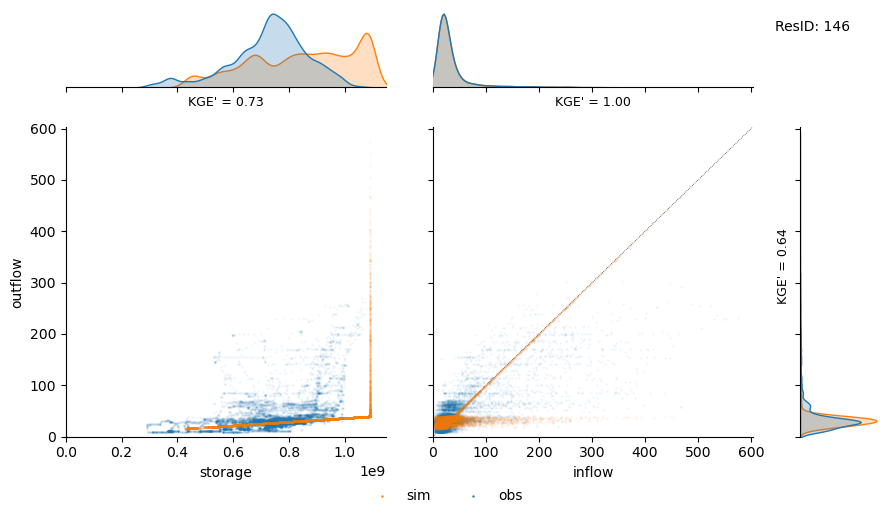

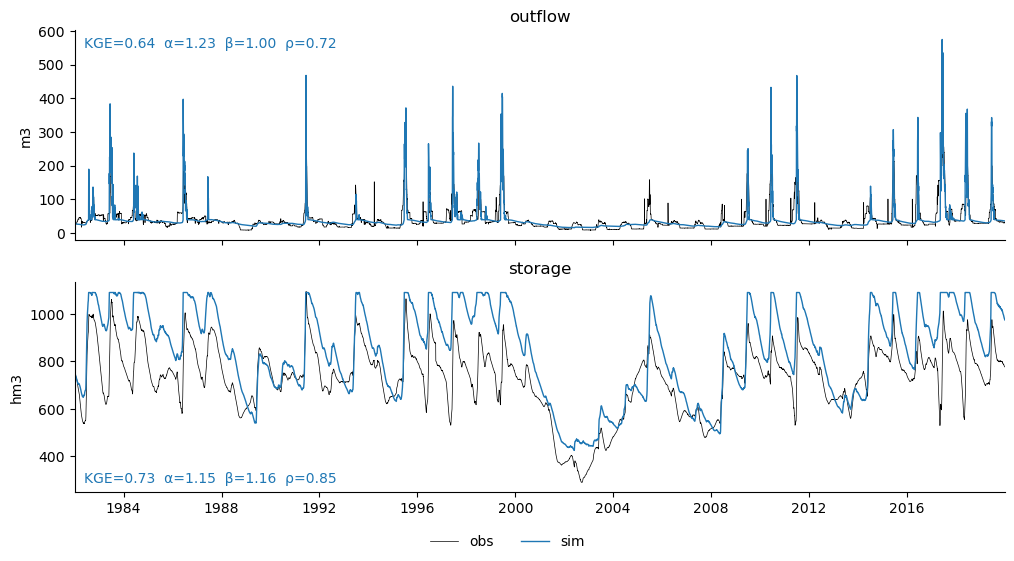

In [81]:
# storage limits
Vmin, Vtot = reservoirs.loc[ResID, ['clim', 'CAP']]
Vtot *= 1e6
Vmin *= Vtot

# outflow limits
Qmin = reservoirs.loc[ResID, 'minq']

# residence time: number of days required to fill the reservoir with the mean inflow
T = Vtot / (obs.inflow.mean() * 24 * 3600)
print(f'residence time = {T:.0f} days')

# declare the reservoir
res = Linear(Vmin, Vtot, Qmin, T=T)

# simulate the reservoir
sim1 = res.simulate(obs.inflow, obs.storage[0])

# analyse simulation
res.scatter(sim1,
            obs,
            norm=False,
            title=f'ResID: {ResID}',
            save=PATH_OUT / f'{ResID}_scatter_default.jpg',
           )
res.lineplot({'sim': sim1},
             obs,
             figsize=(12, 6),
             save=PATH_OUT / f'{ResID}_line_default.jpg',
           )

#### Effect of the residence time
Test the performance for different values of the residence time $T$.

In [82]:
performance = pd.DataFrame(index=range(100, 600, 5), columns=['KGEq', 'KGEs'])
for T in tqdm(performance.index):
    
    # declare the reservoir
    res = Linear(Vmin, Vtot, Qmin, T=T)

    # simulate the reservoir
    sim1 = res.simulate(obs.inflow, obs.storage[0])
    performance.loc[T, :] = [KGEmod(obs[var], sim1[var])[0] for var in ['outflow', 'storage']] 

performance = performance.astype(float)
performance['KGE'] = (1 - (1 - performance).pow(2).sum(axis=1).pow(.5))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

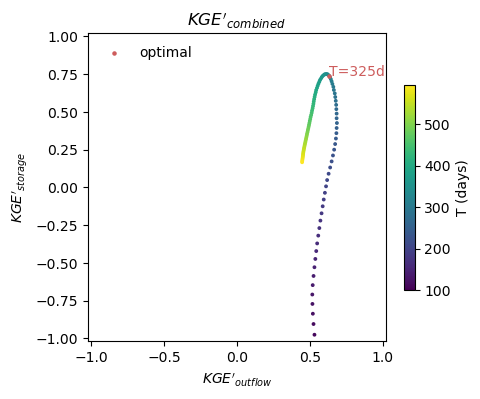

In [92]:
# plot evolution
fig, ax = plt.subplots(figsize=(4.8, 4))
sct = ax.scatter(performance.KGEq, performance.KGEs, c=performance.index, cmap='viridis', s=3, alpha=1)
Topt = performance.KGE.idxmax()
ax.scatter(*performance.loc[Topt, ['KGEq', 'KGEs']], s=5, c='indianred', label='optimal')
ax.text(performance.loc[Topt, 'KGEq'], performance.loc[Topt, 'KGEs'], f'T={Topt}d', color='indianred')
plt.colorbar(sct, shrink=.666, label='T (days)')
ax.set(xlim=(-1.02, 1.02),
       xlabel=r"$KGE'_{outflow}$",
       ylim=(-1.02, 1.02),
       ylabel=r"$KGE'_{storage}$",
       title=r"$KGE'_{combined}$"
      )
ax.legend(frameon=False, loc=2);

plt.savefig(PATH_OUT / f'{ResID}_performance_vs_residence_time.jpg', dpi=300, bbox_inches='tight')

  0%|          | 0/13878 [00:00<?, ?it/s]

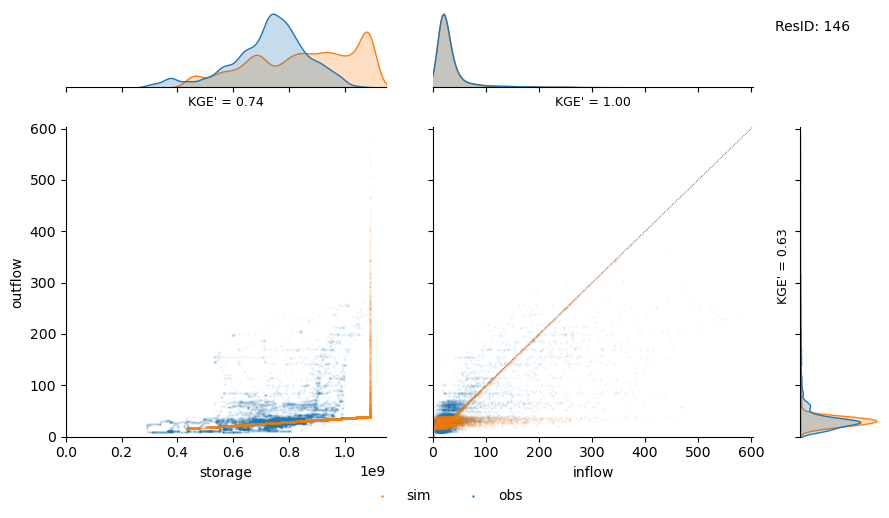

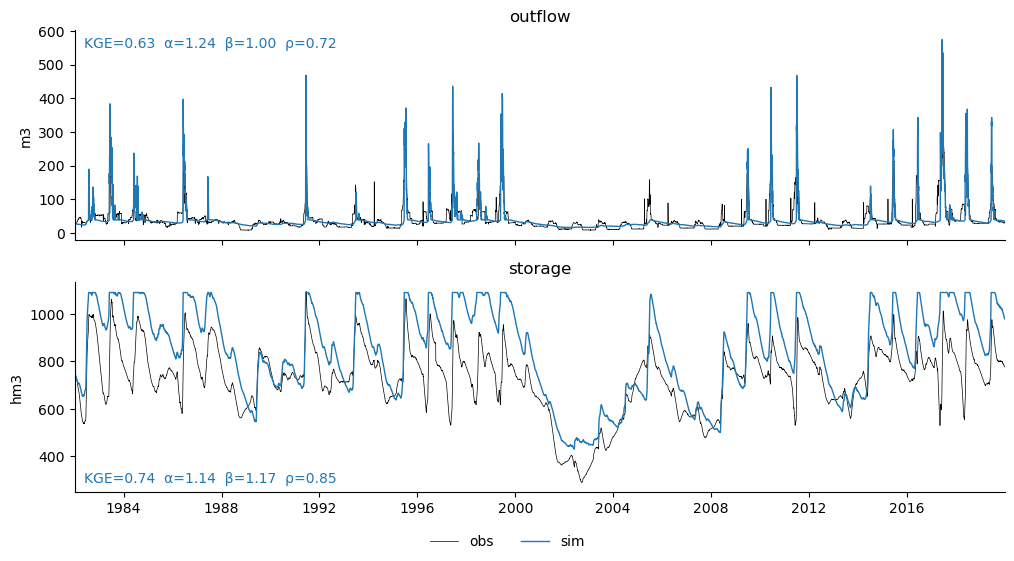

In [84]:
# declare the reservoir
res = Linear(Vmin, Vtot, Qmin, T=Topt)

# simulate the reservoir
sim1 = res.simulate(obs.inflow, obs.storage[0])

# analyse simulation
res.scatter(sim1,
            obs,
            norm=False,
            title=f'ResID: {ResID}',
            save=PATH_OUT / f'{ResID}_scatter_optimal.jpg',
           )
res.lineplot({'sim': sim1},
             obs,
             figsize=(12, 6),
             save=PATH_OUT / f'{ResID}_line_optimal.jpg',
           )